<a href="https://colab.research.google.com/github/enxilin/workforce-allocation/blob/main/workforce3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install docplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 610 kB 4.3 MB/s 
  Created wheel for docplex: filename=docplex-2.23.222-py3-none-any.whl size=662847 sha256=9ad51af6fb402e5db58a1ed12958f9c929237c15a0d0679dc7da4963ca255d44
  Stored in directory: /root/.cache/pip/wheels/a7/c9/fb/cee5a89f304e77a39c466e625ac2830434b76eb8384999d116
Successfully built docplex


In [ ]:
pip install cplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43.3 MB 1.2 MB/s 


In [ ]:
import sys
import docplex.mp
import pandas as pd
import numpy as np
from collections import namedtuple

In [ ]:
eskillsTable = pd.read_csv('/content/drive/My Drive/workforce/Employee Skillset3.csv', sep=",", header=0)
avilibilityTable = pd.read_csv('/content/drive/My Drive/workforce/Employee Availablity3.csv', sep=",", header=0)
tasksTable = pd.read_csv('/content/drive/My Drive/workforce/Production Needs3.csv', sep=",", header=0)
skillsTable = pd.read_csv('/content/drive/My Drive/workforce/skills3.csv', sep=",", header=0)

In [ ]:
def myround(x):
  if x==0:
    return 0
  else:
    return int(round(x)+1)

In [ ]:
# construct employee time table and dictonary:
avilibilityTable.insert(1,"Time","")
for i in range(len(avilibilityTable)):
  start_str=avilibilityTable.iloc[i,3]
  end_str=avilibilityTable.iloc[i,4]
  lunchs_str=avilibilityTable.iloc[i,5]
  lunche_str=avilibilityTable.iloc[i,6]
  starttime=int(start_str[:len(start_str)-3])*2+myround(int(start_str[-2:])/60)
  lunchs=int(lunchs_str[:len(lunchs_str)-3])*2+myround(int(lunchs_str[-2:])/60)
  lunche=int(lunche_str[:len(lunche_str)-3])*2+myround(int(lunche_str[-2:])/60)
  endtime=int(end_str[:len(end_str)-3])*2+myround(int(end_str[-2:])/60)
  #array may be better np.arange(starttime,luchs)
  avilibilityTable.iat[i,1]=list(range(48)[starttime:lunchs])+list(range(48)[lunche:endtime])

employee_time={}
TeTime = namedtuple("TeTime", ["Employee", "timeset"])
for et in avilibilityTable.iloc[:,0:2].itertuples(index=False):
  ett=TeTime(*et)
  employee_time.setdefault(ett.Employee,ett.timeset)

In [ ]:
# build task-time dictionary
tasksTable.insert(1,"Time","")
for i in range(len(tasksTable)):
  taskstart_str=tasksTable.iloc[i,4]
  taskend_str=tasksTable.iloc[i,6]
  taskstart=int(taskstart_str[:len(taskstart_str)-3])*2+myround(int(taskstart_str[-2:])/60)
  taskend=int(taskend_str[:len(taskend_str)-3])*2+myround(int(taskend_str[-2:])/60)
  tasksTable.iat[i,1]=list(range(48)[taskstart:taskend])

task_time={}
TtTime = namedtuple("TeTime", ["Task", "timeset"])
for tt in tasksTable.iloc[:,0:2].itertuples(index=False):
  ttt=TtTime(*tt)
  task_time.setdefault(ttt.Task,ttt.timeset)

In [ ]:
skillslist = [skillsTable["name"][i] for i in range(len(skillsTable))]
employeelist = [avilibilityTable["Employee ID"][i] for i in range(len(avilibilityTable))]
tasklist = [tasksTable["Need ID"][i] for i in range(len(tasksTable))]
timelist=list(range(0,48))

#build task-skill dictionary
TtSkill = namedtuple("TtSkill", ["Task", "skillset"])
task_skill={}
for tsk in tasksTable.iloc[:,[0,2]].itertuples(index=False):
  tskt=TtSkill(*tsk)
  task_skill.setdefault(tskt.Task,tskt.skillset)

#build employee skills dictionary
TeSkill = namedtuple("TeSkill", ["Employee", "skillset"])
employee_skills = {}
for esk in eskillsTable.itertuples(index=False):
    eskt= TeSkill(*esk)
    employee_skills.setdefault(eskt.Employee, []).append(eskt.skillset)

In [ ]:
from docplex.mp.model import Model
mdl = Model("employee")

Define the decision variables

The basic decisions are "which employee works which task at time t", which is modeled by binary variables for each (employee, task, time) pair.

The output of the model is, for each time, the list of employees that work that time.



In [ ]:
employee_task_vars = mdl.binary_var_matrix(employeelist, tasklist, 'EmployeeAssigned')
employee_work_time_vars = mdl.continuous_var_dict(employeelist, lb=0, name='EmployeeWorkTime')
work_start_var=mdl.continuous_var_dict(employeelist)
work_end_var=mdl.continuous_var_dict(employeelist)

In [ ]:
#employee_work_time=[]
for e in employeelist:
    mdl.add_constraint(work_end_var[e]==mdl.max(employee_task_vars[e,t]*task_time[t][-1] for t in tasklist))
    mdl.add_constraint(work_start_var[e]==mdl.max(employee_task_vars[e,t]/task_time[t][0] for t in tasklist))
    mdl.add_constraint(employee_work_time_vars[e]== work_end_var[e]+work_start_var[e])
    #employee_work_time.append(mdl.max(employee_task_vars[e,t]*task_time[t][-1] for t in tasklist)+mdl.max(employee_task_vars[e,t]/task_time[t][0] for t in tasklist))
#total=sum(employee_work_time)

constrain1:when employee are unavaibele, he can not assigned any tasks starting that time.


In [ ]:
for e in employeelist:
  for t in tasklist:
    if all(elem in employee_time[e] for elem in task_time[t])==False: #if one list is a subset of the other list
      mdl.add_constraint(employee_task_vars[e, t] == 0)
      

constrain2: can not assign overlap task; employee perform one task at each t 

In [ ]:
nb_tasks = len(tasksTable)
for i1 in range(nb_tasks):
    for i2 in range(i1 + 1, nb_tasks):
      s1=tasksTable.iloc[i1,0]
      s2=tasksTable.iloc[i2,0]
      if len(set(tasksTable.iloc[i1,1]) & set(tasksTable.iloc[i2,1]))>0:
        for n in employeelist:
          mdl.add_constraint(employee_task_vars[n, s1] + employee_task_vars[n, s2] <= 1)

constrain3: enforce skill requirements for selected task.

In [ ]:
for task in tasklist:
  for employee in employeelist:
    if len(set(employee_skills[employee])& set(task_skill[task]))==0:#check if two lists have common elements
      mdl.add_constraint(employee_task_vars[employee, task] == 0)

constrain4: one task only need one employee

In [ ]:
for s in tasklist:
  total_assigned = mdl.sum(employee_task_vars[n, s] for n in employeelist)
  mdl.add_constraint(total_assigned <= 1)

constrain5: at each time, number of employee assgined to each skill A is less than number of employee masters skill A

In [ ]:
for h in timelist:
  for s in skillslist:
      nb_employee=len(eskillsTable[eskillsTable["Skillset ID"]== s])
      total_assigned=0
      for t in tasksTable[tasksTable["SkillsetID1"]== s]["Need ID"]:
        if h in task_time[t]:
          total_assigned+=mdl.sum(employee_task_vars[e,t] for e in employeelist)
      mdl.add_constraint(total_assigned <=nb_employee)

Define an variable include starting/ending time of one employee
define total work hours

In [ ]:
total_number_of_assignments = mdl.sum(employee_task_vars[e,t] for e in employeelist for t in tasklist)

In [ ]:
total=mdl.sum(employee_work_time_vars[e] for e in employeelist)

In [ ]:
#mdl.add_kpi(total,"total work hours")
mdl.add_kpi(total_number_of_assignments,"number of assigned task")
mdl.print_information()

Model: employee
 - number of variables: 420
   - binary=240, integer=0, continuous=180
 - number of constraints: 689
   - linear=529, indicator=160
 - parameters: defaults
 - objective: none
 - problem type is: MILP


In [ ]:
mdl.maximize(10*total_number_of_assignments-0.1*total)
#mdl.maximize(total_number_of_assignments)

In [ ]:
s = mdl.solve()
mdl.report()

* model employee solved with objective = 190.000
*  KPI: number of assigned task = 19.000


In [ ]:
work_time=[]
for e in employeelist:
  start_time= 47
  end_time=0
  for t in tasklist:
    if employee_task_vars[e,t].solution_value >0:
      start_time = min(task_time[t][0],start_time)
      end_time = max(task_time[t][-1],end_time)
  work_time.append(end_time-start_time+1)
total_work_hours=sum(work_time)
print("The total work hours is",total_work_hours,"hours")

The total work hours is 54 hours


In [ ]:
mdl.print_solution()

objective: 190
  EmployeeAssigned_10001_2001=1
  EmployeeAssigned_10001_2003=1
  EmployeeAssigned_10001_2008=1
  EmployeeAssigned_10001_2011=1
  EmployeeAssigned_10001_2014=1
  EmployeeAssigned_10001_2018=1
  EmployeeAssigned_10002_2002=1
  EmployeeAssigned_10002_2005=1
  EmployeeAssigned_10002_2012=1
  EmployeeAssigned_10002_2016=1
  EmployeeAssigned_10003_2010=1
  EmployeeAssigned_10003_2013=1
  EmployeeAssigned_10003_2017=1
  EmployeeAssigned_10003_2020=1
  EmployeeAssigned_10004_2006=1
  EmployeeAssigned_10004_2007=1
  EmployeeAssigned_10004_2009=1
  EmployeeAssigned_10004_2015=1
  EmployeeAssigned_10004_2019=1
  EmployeeWorkTime_10001=31.062
  EmployeeWorkTime_10002=29.062
  EmployeeWorkTime_10003=31.050
  EmployeeWorkTime_10004=31.050
  x85=0.062
  x86=0.062
  x87=0.050
  x88=0.050
  x89=31.000
  x90=29.000
  x91=31.000
  x92=31.000


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
tmin=int(min(task_time.values())[0])
tmax=int(max(task_time.values())[-1]+1)
def createLabels(ax, title, xlabel, ylabel):
  plt.xticks(np.arange(tmin,tmax),["{}".format(str(s/2)) for s in timelist[tmin:tmax]])
  plt.xlim([tmin,tmax])
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.grid()
  ax.set_title(title)

colorBySkills = {}
for d, c in zip(skillslist, ['r', 'm', 'b', 'g', 'y', 'c']):
    colorBySkills[d] = c

colors=['k','r', 'm', 'b', 'g', 'y', 'c']
labels=['avilibility','A','B','C','D','E','F']
red_patch = [mpatches.Patch(color=colors[i], label=labels[i])for i in range(len(labels))]


In [ ]:
def unassignTask(assignlist):
  for e in employeelist:
    for t in tasklist:
      if employee_task_vars[e,t].solution_value > 0:
        assignlist.append(t)
        unassignlist=list(set(tasklist) - set(assignlist))
  for i in unassignlist:
    print(i,": from",task_time[i][0]/2,"to",task_time[i][-1]/2+0.5,",required skillset:",task_skill[i])

In [ ]:
def displayTasksAssignmentsGantt(ax):
    ylabels, tickloc = [], []
    for i in range(len(employeelist)):
      n=employeelist[i]
      lunchs_str=avilibilityTable["Lunch Start"][i]
      lunchs=int(lunchs_str[:len(lunchs_str)-3])*2+myround(int(lunchs_str[-2:])/60)
      ax.bar(employee_time[n][0],0.3,width=lunchs-employee_time[n][0],bottom=i+0.5,color='k',align='edge')
      ax.bar(lunchs+2,0.3,employee_time[n][-1]-lunchs-1,bottom=i+0.5,color='k',align='edge')
      for s in tasklist:
        if employee_task_vars[n,s].solution_value > 0:
          ax.bar(task_time[s][0], 0.4,
                 width=task_time[s][-1] - task_time[s][0]+0.95, bottom=i + 0.1,
                 color=colorBySkills[task_skill[s]],align='edge')
                  
      ylabels.append("{}:{}".format(str(n),employee_skills[n])) # (3)number of total hours works
      tickloc.append(i + 0.5)

    plt.ylim(0, len(employeelist))
    plt.yticks(tickloc, ylabels)
    plt.legend(handles=[red_patch][0]) #[0] beacuse error:'list' object has no attribute 'get_label'

    # Create labels on x/y axis
    createLabels(ax, 'Taks Assignments', 'Hours Of The Day', 'Employee ID & Skill')


2004 : from 9.0 to 9.5 ,required skillset: B


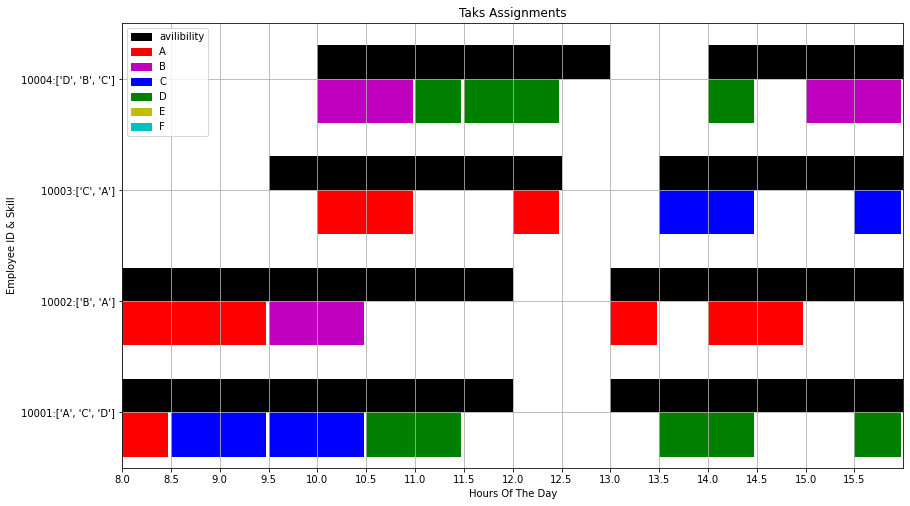

In [ ]:
fig = plt.figure(figsize=[14,12])
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])

ax = plt.subplot(gs[0])
displayTasksAssignmentsGantt(ax)
unassignTask([])